# Colloborative filtering with NMF Matrix Factorization

**Objective: To build and evaluate a collaborative filtering with NMF factorization based recommender**

In [2]:
#Import the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import random
import zipfile

## Getting the data

In [3]:
#Getting the dataset
dataset_urls=[
    'http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip',
    'http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip',
    'http://files.grouplens.org/datasets/hetrec2011/hetrec2011-delicious-2k.zip'
]

dataset_url=dataset_urls[0]
dataset_name=dataset_url[dataset_url.rfind('/')+1:]

# Download the dataset
import requests
r = requests.get(dataset_url, allow_redirects=True)
open(dataset_name, 'wb').write(r.content)

18856822

## Reading the target file in pandas

In [4]:
# inspect the files in the dataset
print('Files in ', dataset_name)
with zipfile.ZipFile(dataset_name) as z:
    for name in z.namelist():
        print(name)
print()

# We use the file that contains user, items, and their ratings
target_file='user_ratedmovies-timestamps.dat'
print('Initial content in ', target_file)
with zipfile.ZipFile(dataset_name) as z:
   with z.open(target_file) as f:
      data = pd.read_csv(f, header=0, delimiter="\t")
      print(data.head())    

Files in  hetrec2011-movielens-2k-v2.zip
user_taggedmovies-timestamps.dat
movie_actors.dat
movie_countries.dat
movie_directors.dat
movie_genres.dat
movie_locations.dat
movie_tags.dat
movies.dat
readme.txt
tags.dat
user_ratedmovies.dat
user_ratedmovies-timestamps.dat
user_taggedmovies.dat

Initial content in  user_ratedmovies-timestamps.dat
   userID  movieID  rating      timestamp
0      75        3     1.0  1162160236000
1      75       32     4.5  1162160624000
2      75      110     4.0  1162161008000
3      75      160     2.0  1162160212000
4      75      163     4.0  1162160970000


## Reading the movies data

In [5]:
target_file='movies.dat'
print('Initial content in ', target_file)
with zipfile.ZipFile(dataset_name) as z:
   with z.open(target_file) as f:
      movies = pd.read_csv(f, header=0, delimiter="\t",encoding = 'ISO-8859-1')
    
movies.head()

Initial content in  movies.dat


,id,title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,...,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,...,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...


In [6]:
#joining the ratings data with movies to get the movie names
data2 = data.merge(movies,how = 'left',left_on = 'movieID', right_on = 'id')

In [7]:
#Final ratings data with movie names
ratings = data2[['userID','movieID','rating','title']]

## Splitting the data for future evaluation

In [8]:
# random.seed(1)

# ratio=0.8 # 80% of the data is kept in training
# mask = np.random.rand(len(ratings)) < ratio
# train_ratings = ratings[mask]
# test_ratings = ratings[~mask]

# pd.to_pickle(train_ratings, 'train_df', protocol=4)
# pd.to_pickle(test_ratings, 'test_df', protocol=4)

In [9]:
#Loading the whole data from pickle files
train_ratings = pd.read_pickle('train_df')
test_ratings = pd.read_pickle('test_df')

print(f'Total:{len(ratings)}, Train: {len(train_ratings)},Test:{len(test_ratings)}')

Total:855598, Train: 683989,Test:171609


In [10]:
#check if every user which is in test data is also in training

set(test_ratings['userID']).difference(set(train_ratings['userID']))

set()

In [11]:
#check if every movie which is in test data is also in training

len(set(test_ratings['movieID']).difference(set(train_ratings['movieID'])))

130

In [12]:
#these movies should not be considered when evaluting the recommender
excluded_movies = set(test_ratings['movieID']).difference(set(train_ratings['movieID']))

In [13]:
#Utility matrix for user based similarities (users in rows and items in columns)
from scipy.sparse import csr_matrix

def create_X_users(df):
    """
    Generates a sparse matrix from ratings dataframe. (Users * Items)

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userID'].nunique()
    N = df['movieID'].nunique()

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(M))))
    movie_mapper = dict(zip(np.unique(df["movieID"]), list(range(N))))
    movie_name_mapper = dict(zip(ratings['movieID'],ratings['title']))

    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userID"])))
    movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieID"])))

    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [movie_mapper[i] for i in df['movieID']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper,movie_name_mapper

user_item_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper,movie_name_mapper = create_X_users(train_ratings)


In [14]:
user_item_matrix.shape,user_item_matrix.count_nonzero()

((2113, 9979), 683989)

## User Item matrix factorization using NMF

In [15]:
from sklearn.decomposition import NMF

num_factors= 10
model = NMF(n_components=num_factors)
W = model.fit_transform(user_item_matrix)
H = model.components_
print(W.shape, H.shape)

/Users/shubhammehta/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


(2113, 10) (10, 9979)


/Users/shubhammehta/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [16]:
#new user item matrix

new_user_item_matrix = model.inverse_transform(W)

In [17]:
# from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=20, n_iter=10)
# Z = svd.fit_transform(user_item_matrix)

# new_user_item_matrix = svd.inverse_transform(Z)

## Latent factor based recommendations : Top 10

In [18]:
def candidate_items_for_user(df, user):
    """
    Returns the candidate movies which can be recommended to a uset

    Args:
        data: train ratings data (pandas dataframe)

    Returns:
        a set of candidate movie id's
    """
    all_movies = set(df['movieID'].unique())
    user_movies = set(df[df['userID'] == user]['movieID'].unique())
    cand_items = all_movies.difference(user_movies)
    return set(cand_items)

In [19]:
def latent_factor_based_recommender(df,user):
    """
    Generates a dictionary with movies as keys and predicted ratings a values for a user (sorted by values in desc)

    Args:
        df: training ratings data (pandas dataframe)
        user: userid (int)

    Returns:
        A dictionary of movies, predicting ratings sorted by predicted ratings
    """
    
    cand_scores = {}

    cand_items = candidate_items_for_user(train_ratings,75)
    for movie_id in cand_items:
        movie_index = movie_mapper[movie_id]
        cand_scores[movie_id] = new_user_item_matrix[user_mapper[75],movie_index]
    return dict(sorted(cand_scores.items(),key = lambda cand_scores:cand_scores[1],reverse = True))

In [20]:
#top 10 recommendations for a user
for i,movieid in enumerate(latent_factor_based_recommender(train_ratings,75)):
    if i <=9:
        print(i+1,movie_name_mapper[movieid])

1 The Matrix
2 Forrest Gump
3 Fight Club
4 The Shawshank Redemption
5 Star Wars
6 Shrek
7 Star Wars: Episode V - The Empire Strikes Back
8 Gladiator
9 Pirates of the Caribbean: The Curse of the Black Pearl
10 Minority Report


## Evaluating the recommender

In [21]:
#since every user in the test is present in train, we will evalute the recommender on all the users

#since not every movie which is in test, is not in train we will exclude those movies as there is no way that
#our recommnder gives prediction for those movies

def evaluate_recommender(test_df):
    """
    Generates the MAE and RMSE score

    Args:
        test_df: testing ratings data (pandas dataframe)
    Returns:
        MAE and RMSE score (tuple)
    """
    test_df = test_df[~test_df['movieID'].isin(excluded_movies)]      #exclude the excluded movies
    
    abs_err,sq_err,n = 0,0,0
    for userid in set(test_df['userID']):
        user_index = user_mapper[userid]
        user_test_df = test_df[test_df['userID'] == userid]
        user_test_movies = list(user_test_df['movieID'])
        user_actual_ratings = np.array(user_test_df[user_test_df['movieID'] == user_test_movies]['rating'])
        user_test_movies_indexes = [movie_mapper[x] for x in user_test_movies]
        user_pred_ratings = np.array(new_user_item_matrix[user_index][user_test_movies_indexes])
        
        abs_err += np.sum(np.abs(np.subtract(user_actual_ratings,user_pred_ratings)))
        sq_err += np.sum(np.subtract(user_actual_ratings,user_pred_ratings)**2)
        n += len(user_actual_ratings)
        
    mae = abs_err/n
    rmse = np.sqrt(sq_err/n)
    
    return mae,rmse

In [37]:
#checking the number of factors and corresponding test and train errors

import warnings
warnings.filterwarnings("ignore")

latent_factors = []
train_mae = []
train_rmse = []
test_mae = []
test_rmse = []


for num_factors in np.arange(10,200+10,20):

    model = NMF(n_components=num_factors)
    W = model.fit_transform(user_item_matrix)
    new_user_item_matrix = model.inverse_transform(W)
    latent_factors.append(num_factors)
    
    #train errors
    train_err = evaluate_recommender(train_ratings)
    train_mae.append(train_err[0])
    train_rmse.append(train_err[1])
    
    #test errors
    test_err = evaluate_recommender(test_ratings)
    test_mae.append(test_err[0])
    test_rmse.append(test_err[1])

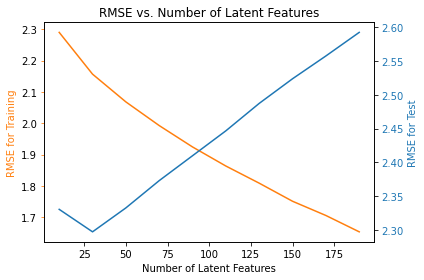

In [38]:
# plotting the train and test accuracies
fig, ax1 = plt.subplots()

color = 'tab:orange'
ax1.set_xlabel('Number of Latent Features')
ax1.set_ylabel('RMSE for Training',color=color)
ax1.plot(latent_factors, train_mae, color=color)

ax1.tick_params(axis='y',color=color)
ax1.set_title('RMSE vs. Number of Latent Features')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('RMSE for Test', color=color)
ax2.plot(latent_factors, test_mae, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

**From above plot, we can see that the accuracy for the training data increases with an increase in the number of latent features, however the opposite is true for the accuracy of the test data. This is most likely due to overfitting of the data with the increase in latent features, therefore the number of latent features should be kept around 30** 

**When using NMF we often experience the cold start problem. That is, we can only make predictions for movies and users that exist in both the training and test sets. For users in the test dataset that are not in the training set, we cannot predict movies to recommend to that user. To improve upon our recommendation engine for new users, we could use a blended techniques of collaborative filtering based, and content based recommendations. We could also conduct an A/B test to best understand which recommendation technique should be employed.**